## Import necessary modules and data

In [7]:
import numpy as np
import pandas as pd
import sklearn
import keras
import seaborn
import matplotlib.pyplot as plt
import tensorflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
#!pip install -q keras_metrics
import keras_metrics
from sklearn.model_selection import cross_validate
#!pip install livelossplot
from livelossplot import PlotLossesKeras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import precision_recall_fscore_support as score
import random


## Wczytujemy poprzednio utworzone zbiory

In [8]:
X = pd.read_csv('../data/cleaned_data.csv', index_col=0)
y = pd.read_csv('../data/labels.csv', header = None)

X_test = pd.read_csv('../data/X_test.csv', index_col=0)
X_train = pd.read_csv('../data/X_train.csv', index_col=0)


y_train = pd.read_csv('../data/y_train.csv', index_col=0)
y_test = pd.read_csv('../data/y_test.csv', index_col=0)

## Wyrzucam również informację odnośnie posiadania karty kredytowej - korelacja ze zmienną objaśnianą wynosiła 0.0003

In [9]:
X_train = X_train.drop(['HasCrCard'], axis=1)
X_test = X_test.drop(['HasCrCard'], axis=1)

In [10]:
scaler = StandardScaler().fit(X_train)

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

/home/seba/.virtualenvs/rl/lib/python3.5/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/seba/.virtualenvs/rl/lib/python3.5/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/seba/.virtualenvs/rl/lib/python3.5/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.



## Poza standaryzacja i stratyfikacją zbioru treningowego i testowego ustalam również wagi dla danych klas

In [11]:
class_weight = {
                0: 3.,
                1: 1.
               }

es = EarlyStopping(monitor='val_precision', mode='max', verbose=1, patience=3)

## Buduję pierwszy model
W callbacku korzystam z metody PlotLossesKeras(), która umożliwi nam tworzenie interesujących nas wykresów danych metryk w czasie rzeczywistym korzystam również z early stopping zdefiniowanego wyżej, aby nie dopuścić do przetrenowania modelu.

Sprawdźmy jednak najpierw, jak mieni nam się nasza metryka na zbiorze treningowym i walidacyjnym - użyjemy do tego metody PlotLossesKeras, która w sposób graficzny przedstawi nam powyższe metryki.

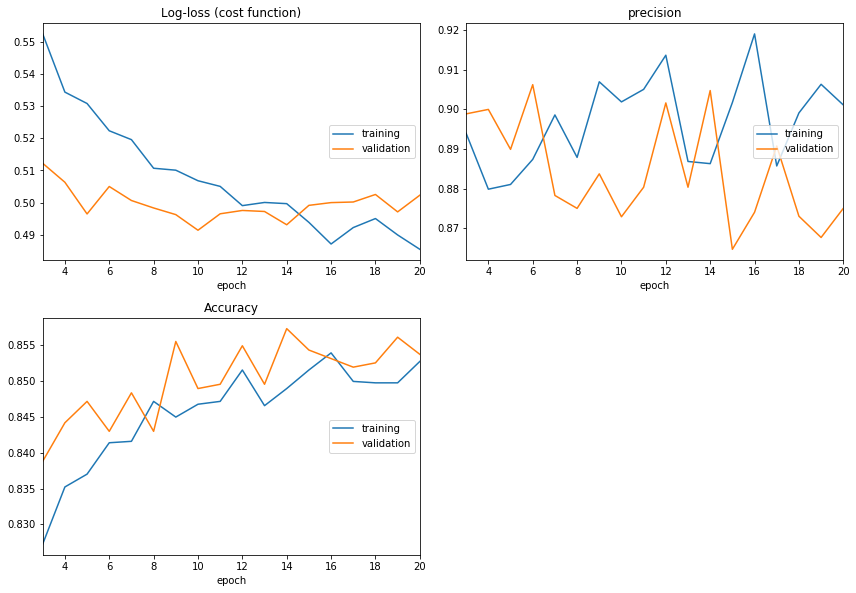

Log-loss (cost function):
training   (min:    0.485, max:    0.671, cur:    0.485)
validation (min:    0.491, max:    0.598, cur:    0.502)

precision:
training   (min:    0.714, max:    0.919, cur:    0.901)
validation (min:    0.865, max:    1.000, cur:    0.875)

Accuracy:
training   (min:    0.797, max:    0.854, cur:    0.853)
validation (min:    0.801, max:    0.857, cur:    0.854)


In [12]:
model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(9,)))


model.add(Dropout(0.1,))
model.add(Dense(75, activation='relu'))


model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[keras_metrics.precision(),'accuracy'])
                   
model.fit(X_train_std, y_train, epochs=20, batch_size=2,
           verbose=1, validation_split=0.25, callbacks = [PlotLossesKeras()], class_weight=class_weight)

## Właściwy model z metodą wczesnego stopowania

Widzimy już, jak wyglądają wykresy funkcji straty na zbiorze walidacyjnym i treningowym wraz ze zwiększającymi się epokami. Użyjmy teraz wyżej wymienionej metody, aby nie dopuścić do przetrenowania. |

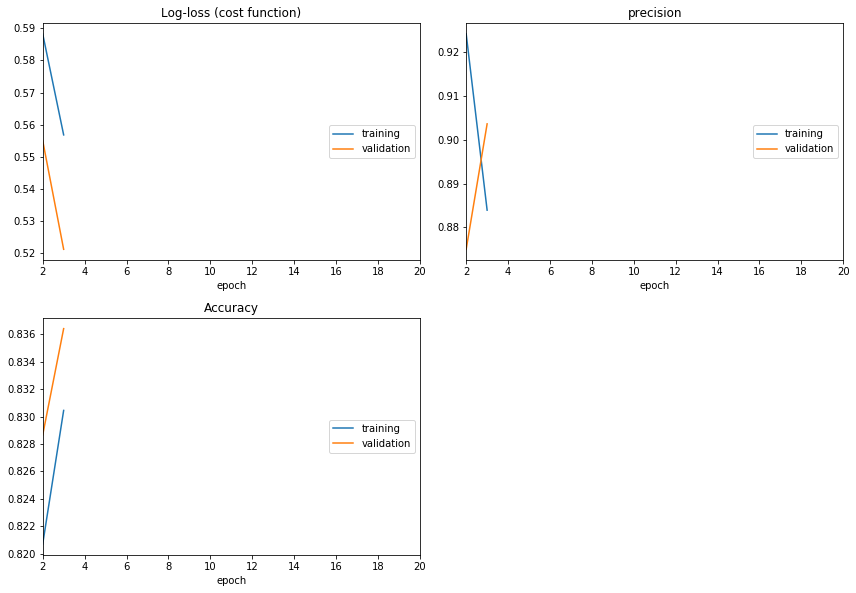

Log-loss (cost function):
training   (min:    0.557, max:    0.675, cur:    0.557)
validation (min:    0.521, max:    0.599, cur:    0.521)

precision:
training   (min:    0.736, max:    0.924, cur:    0.884)
validation (min:    0.875, max:    0.904, cur:    0.904)

Accuracy:
training   (min:    0.801, max:    0.830, cur:    0.830)
validation (min:    0.800, max:    0.836, cur:    0.836)
Epoch 4/20
4988/5025 [============================>.] - ETA: 0s - loss: 0.5331 - precision: 0.8914 - acc: 0.8384

In [ ]:
model_2 = Sequential()
model_2.add(Dense(20, activation='relu', input_shape=(9,)))


model_2.add(Dropout(0.1,))
model_2.add(Dense(75, activation='relu'))


model_2.add(Dense(1, activation='sigmoid'))


model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[keras_metrics.precision(),'accuracy'])
                   
model_2.fit(X_train_std, y_train, epochs=20, batch_size=2,
           verbose=1, validation_split=0.25, callbacks = [PlotLossesKeras(), es], class_weight=class_weight)

## Sprawdźmy predykcję i wygenerujmy raport klasyfikacyjny

In [ ]:
y_pred = model_2.predict_classes(X_test_std)

report = classification_report(y_test, y_pred, output_dict=False)
print(report)

## Zapisujemy wytrenowany model

In [ ]:
model.save_weights("../saved_models/model_2.h5")

### autor: Paweł Bogdan